# 章節 15：維度處理

## 15.1 獅子、老虎和熊

先從簡單的問題開始，假設只有三種物種。分別是獅子、老虎和熊。假設我們參訪一個野生動物保護區看到 3 隻獅子、2 隻老虎和 1 隻熊。如果我們在此保護區看到任何動物的機率都一樣，我們看到的每個物種的數量由多項式分佈（Multinomal distribution）決定。如果獅子、老虎和熊的流行程度是 p_lion、p_tiger 和 p_bear，則看到 3 隻獅子、2 隻老虎和 1 隻熊的似然性（likelihood）與以下成正比

$$ p\_lion^3 * p\_tiger^2 * p\_bear^1$$

有一種接近但是不正確的方式是用 Beta 分佈，如 4.5 小節用在硬幣問題，去分別描述每個物種的流行程度。例如，我們看到 3 隻獅子和 3 隻非獅子；也就是想成 3 次正面硬幣跟 3 次反面硬幣，而 p_lion 的後驗分佈是：

獅子 MLE: 50.0 %
0.0 0.49999999999999967
老虎 MLE: 33.0 %
0.0 0.3750000218728134
熊 MLE: 17.0 %
0.0 0.2500875043752188


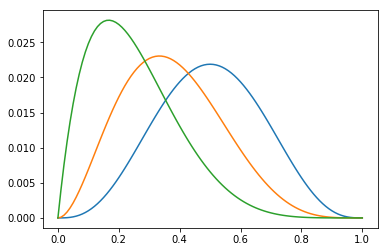

In [24]:
import thinkbayes as tb
import matplotlib.pyplot as plt

def plot_dist(dist, c=None):
    x, y = zip(*sorted(dist.Items()))
    plt.plot(x, y, c=c)

def beta_mle(positive, negative, title):
    beta = tb.Beta()
    beta.Update((positive, negative))
    pmf = beta.MakePmf()
    print(title, "MLE:", pmf.MaximumLikelihood()*100, "%")
    print(pmf.Prob(0), pmf.Mean())
    plot_dist(pmf)
    
beta_mle(3, 3, "獅子")
beta_mle(2, 4, "老虎")
beta_mle(1, 5, "熊")

p_lion, p_tiger 和 p_bear 的最大似然估計分別是 50%、33% 跟 17%。但有兩個問題：
 
1. 我們隱含的認為每個物種的先驗是由 0 到 1 的均勻分佈，但我們知道總共有三個物種，所以正確的先驗應該是的平均值 1/3，而且任何物種 100% 的似然性應該是 0。
1. 每個物種的分佈不是獨立的，因為出現的機率加總要為 1。為了捕捉到這個相關性，我們需要對這三個物種計算聯合分佈。

我們可以用 Dirichlet 分佈來解決以上兩個問題（參考 http://en.wikipedia.org/wiki/Dirichlet_distribution ）。相同的，我們用 Beta 分佈描述一個有偏差的硬幣，我們也可以用 Dirichlet 分佈來描述 p_lion、p_tiger 和 p_bear 的聯合分佈。

Dirichlet 分佈是 Beta 分佈的多維一般化的版本。相較於只有兩種可能的結果，像是「正面」及「反面」，Dirichlet 分佈可以處理兩個以上的結果：本例就是三個物種。若有 n 種結果，Dirichlet 分佈用 n 個參數來描述，寫作 α1 到 αn。

這邊是 thinkbayes.py 中 Dirichlet 類別的定義：

<pre>
class Dirichlet(object):
    def __init__(self, n):
        # n 表示有多少維度
        self.n = n
        
        # 將每個維度的參數初始化成 1，這邊用 numpy array 儲存參數可以有 numpy 陣列操作的好處
        self.params = numpy.ones(n, dtype=numpy.int)
</pre>

給定一個 Dirichlet 分佈，每種物種的邊際分佈（marginal distribution）服從一個 Beta 分佈，我們可以如下計算：

<pre>
# class Dirichlet(object):

def MarginalBeta(self, i):
    # i 是第幾個參數的邊際分佈
    
    # alpha0: 所有參數的總和
    alpha0 = self.params.sum()
    
    # alpha 是特定種類的參數
    alpha = self.params[i]
    return Beta(alpha, alpha0-alpha)
</pre>


In the example, the prior marginal distribution for each species is Beta(1, 2). We can compute the prior means like this:
    dirichlet = thinkbayes.Dirichlet(3)
    for i in range(3):
        beta = dirichlet.MarginalBeta(i)
        print beta.Mean()
As expected, the prior mean prevalence for each species is 1/3.
To update the Dirichlet distribution, we add the observations to the param- eters like this:
    def Update(self, data):
        m = len(data)
        self.params[:m] += data
Here data is a sequence of counts in the same order as params, so in this example, it should be the number of lions, tigers and bears.
170 Chapter15. DealingwithDimensions
  0.035 0.030 0.025 0.020 0.015 0.010 0.005
0.000
0.0 0.2
0.4 0.6 0.8 1.0 Prevalence
    
lions tigers bears
                
    
Figure 15.1: Distribution of prevalences for three species.
data can be shorter than params; in that case there are some species that have not been observed.
Here’s code that updates dirichlet with the observed data and computes the posterior marginal distributions.
    data = [3, 2, 1]
    dirichlet.Update(data)
    for i in range(3):
        beta = dirichlet.MarginalBeta(i)
        pmf = beta.MakePmf()
        print i, pmf.Mean()
Figure 15.1 shows the results. The posterior mean prevalences are 44%, 33%, and 22%.
